<a href="https://colab.research.google.com/github/naval55/Sentiment_analyzis/blob/main/sentiment_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Conv1D, LeakyReLU
from tensorflow.keras import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import joblib
import unicodedata
import warnings

In [ ]:
selected_stock = 'BTC'


tweets_data = pd.read_csv('/content/twitter-new.csv')
# Filter tweets for a specific stock
filtered_tweets = tweets_data[tweets_data['Stock Name'] == selected_stock]
print(filtered_tweets.shape)
filtered_tweets.head()

(4089, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 22:40:47+00:00,@Cointelegraph @elonmusk @Tesla #Bitcoin Trade...,BTC,Bitcoin
1,2022-09-29 22:23:54+00:00,@adhicutting Crypto/#Bitcoin fixes this hopefu...,BTC,Bitcoin
2,2022-09-29 18:34:51+00:00,I'm so curious about the opening movements of ...,BTC,Bitcoin
3,2022-09-29 15:57:59+00:00,@MorningBrew Tesla and Bitcoin….great balance ...,BTC,Bitcoin
4,2022-09-29 15:10:30+00:00,Good afternoon and Bitcoin is trending as numb...,BTC,Bitcoin


In [ ]:
# Prepare sentiment analysis
sentiment_data = filtered_tweets.copy()
sentiment_data["sentiment"], sentiment_data["neg_score"], sentiment_data["neu_score"], sentiment_data["pos_score"] = '', '', '', ''
sentiment_data.head()

,Date,Tweet,Stock Name,Company Name,sentiment,neg_score,neu_score,pos_score
0,2022-09-29 22:40:47+00:00,@Cointelegraph @elonmusk @Tesla #Bitcoin Trade...,BTC,Bitcoin,,,,
1,2022-09-29 22:23:54+00:00,@adhicutting Crypto/#Bitcoin fixes this hopefu...,BTC,Bitcoin,,,,
2,2022-09-29 18:34:51+00:00,I'm so curious about the opening movements of ...,BTC,Bitcoin,,,,
3,2022-09-29 15:57:59+00:00,@MorningBrew Tesla and Bitcoin….great balance ...,BTC,Bitcoin,,,,
4,2022-09-29 15:10:30+00:00,Good afternoon and Bitcoin is trending as numb...,BTC,Bitcoin,,,,


In [ ]:
import nltk
nltk.download('vader_lexicon')

sentiment_analyzer = SentimentIntensityAnalyzer()
for index, row in sentiment_data.iterrows():
    try:
        tweet = unicodedata.normalize('NFKD', sentiment_data.loc[index, 'Tweet'])
        sentiment_result = sentiment_analyzer.polarity_scores(tweet)
        sentiment_data.at[index, 'sentiment'] = sentiment_result['compound']
        sentiment_data.at[index, 'neg_score'] = sentiment_result['neg']
        sentiment_data.at[index, 'neu_score'] = sentiment_result['neu']
        sentiment_data.at[index, 'pos_score'] = sentiment_result['pos']
    except TypeError:
        print(sentiment_data.loc[index, 'Tweet'])
        print(index)
        break

sentiment_data.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,Date,Tweet,Stock Name,Company Name,sentiment,neg_score,neu_score,pos_score
0,2022-09-29 22:40:47+00:00,@Cointelegraph @elonmusk @Tesla #Bitcoin Trade...,BTC,Bitcoin,0.7269,0.0,0.835,0.165
1,2022-09-29 22:23:54+00:00,@adhicutting Crypto/#Bitcoin fixes this hopefu...,BTC,Bitcoin,0.481,0.0,0.615,0.385
2,2022-09-29 18:34:51+00:00,I'm so curious about the opening movements of ...,BTC,Bitcoin,0.3804,0.0,0.902,0.098
3,2022-09-29 15:57:59+00:00,@MorningBrew Tesla and Bitcoin….great balance ...,BTC,Bitcoin,0.2003,0.15,0.643,0.207
4,2022-09-29 15:10:30+00:00,Good afternoon and Bitcoin is trending as numb...,BTC,Bitcoin,0.4939,0.0,0.802,0.198


In [ ]:
# Process date and group data
sentiment_data['Processed_Date'] = pd.to_datetime(sentiment_data['Date']).dt.date
grouped_sentiment = sentiment_data.drop(columns=['neg_score', 'pos_score', 'neu_score', 'Stock Name', 'Company Name'])
grouped_sentiment = grouped_sentiment.groupby(['Processed_Date']).mean()
print(grouped_sentiment.shape)
grouped_sentiment.head()

(365, 1)


<ipython-input-5-68a975220b79>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_sentiment = grouped_sentiment.groupby(['Processed_Date']).mean()


,sentiment
Processed_Date,
2021-09-30,0.296120
2021-10-01,0.290775
2021-10-02,-0.035833
2021-10-03,0.000000
2021-10-04,0.260075


In [ ]:
stock_data = pd.read_csv('/content/bitcoin-2.csv')
print(stock_data.shape)
stock_data.head()

(252, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,30/09/2021,177.328520,163.361936,147.005248,167.435120,183.275017,5.476374e+07,BTC
1,01/10/2021,162.204304,171.683408,163.533281,182.483421,154.975722,5.782171e+07,BTC
2,04/10/2021,143.865716,160.936774,153.624429,151.401098,166.814069,8.029213e+07,BTC
3,05/10/2021,170.558847,164.952035,169.047232,145.118427,158.063927,6.870450e+07,BTC
4,06/10/2021,147.553640,164.553901,172.094718,169.704663,156.602145,5.362099e+07,BTC


In [ ]:
stock_data['Processed_Date'] = pd.to_datetime(stock_data['Date'], dayfirst=True).dt.date
selected_stock_data = stock_data[stock_data['Stock Name'] == selected_stock]

# Combine stock data with sentiment data
combined_stock_data = selected_stock_data.join(grouped_sentiment, on="Processed_Date", how="left")
combined_stock_data = combined_stock_data.drop(columns=['Stock Name'])
print(combined_stock_data.shape)
combined_stock_data.head()

(252, 9)


,Date,Open,High,Low,Close,Adj Close,Volume,Processed_Date,sentiment
0,30/09/2021,177.328520,163.361936,147.005248,167.435120,183.275017,5.476374e+07,2021-09-30,0.296120
1,01/10/2021,162.204304,171.683408,163.533281,182.483421,154.975722,5.782171e+07,2021-10-01,0.290775
2,04/10/2021,143.865716,160.936774,153.624429,151.401098,166.814069,8.029213e+07,2021-10-04,0.260075
3,05/10/2021,170.558847,164.952035,169.047232,145.118427,158.063927,6.870450e+07,2021-10-05,0.496767
4,06/10/2021,147.553640,164.553901,172.094718,169.704663,156.602145,5.362099e+07,2021-10-06,-0.014157


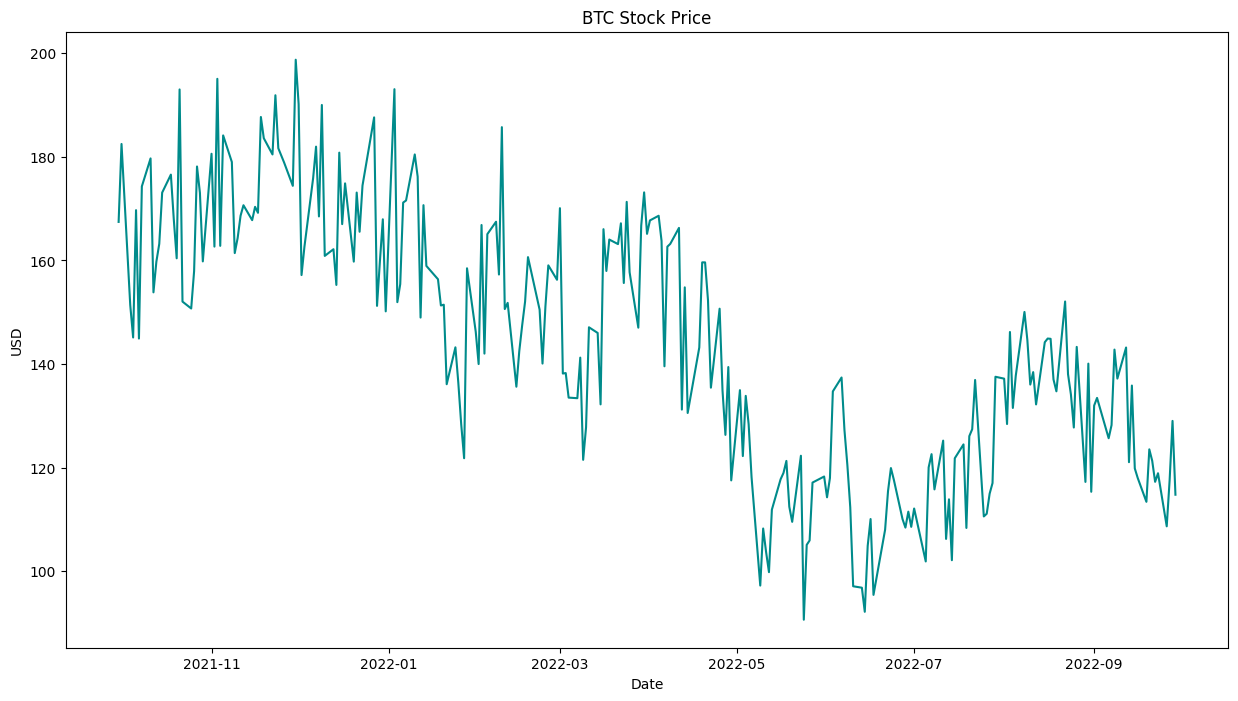

In [ ]:
# Plot the closing price
fig, axis = plt.subplots(figsize=(15,8))
axis.plot(combined_stock_data['Processed_Date'], combined_stock_data['Close'], color='#008B8B')
axis.set(xlabel="Date", ylabel="USD", title=f"{selected_stock} Stock Price")
axis.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.show()

In [ ]:
# Technical indicators
def calculate_indicators(stock_data):
    stock_data['SMA7'] = stock_data['Close'].rolling(window=7).mean()
    stock_data['SMA20'] = stock_data['Close'].rolling(window=20).mean()
    stock_data['MACD_Value'] = stock_data['Close'].ewm(span=26).mean() - stock_data['Open'].ewm(span=12, adjust=False).mean()
    stock_data['StdDev20'] = stock_data['Close'].rolling(20).std()
    stock_data['Upper_Band'] = stock_data['SMA20'] + (stock_data['StdDev20'] * 2)
    stock_data['Lower_Band'] = stock_data['SMA20'] - (stock_data['StdDev20'] * 2)
    stock_data['EMA_Value'] = stock_data['Close'].ewm(com=0.5).mean()
    stock_data['Log_Momentum'] = np.log(stock_data['Close'] - 1)
    return stock_data

technical_stock_data = calculate_indicators(combined_stock_data)
technical_stock_data = technical_stock_data.iloc[20:].reset_index(drop=True)
technical_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Processed_Date,sentiment,SMA7,SMA20,MACD_Value,StdDev20,Upper_Band,Lower_Band,EMA_Value,Log_Momentum
0,28/10/2021,176.687786,167.692805,156.677381,173.055994,151.812724,1.224806e+08,2021-10-28,0.265082,166.473009,165.364906,-6.900886,13.454935,192.274776,138.455036,172.382429,5.147820
1,29/10/2021,162.881618,158.319833,171.899181,159.809611,155.776050,1.281980e+08,2021-10-29,0.306159,166.387596,164.231215,-5.906479,12.879569,189.990354,138.472076,164.000551,5.067706
2,01/11/2021,190.200169,172.805235,173.014132,180.594438,169.262026,7.703264e+07,2021-11-01,0.218536,164.613649,165.690882,-7.440330,13.002659,191.696199,139.685565,175.063142,5.190701
3,02/11/2021,179.291959,184.536003,161.189942,162.667640,173.107650,5.235060e+07,2021-11-02,0.172643,166.130836,166.568343,-8.568611,12.102259,190.772861,142.363825,166.799474,5.085543
4,03/11/2021,148.691899,163.917694,169.920419,195.064051,157.433527,7.685561e+07,2021-11-03,0.130729,172.466133,167.836312,-2.025851,13.674492,195.185296,140.487329,185.642525,5.268188


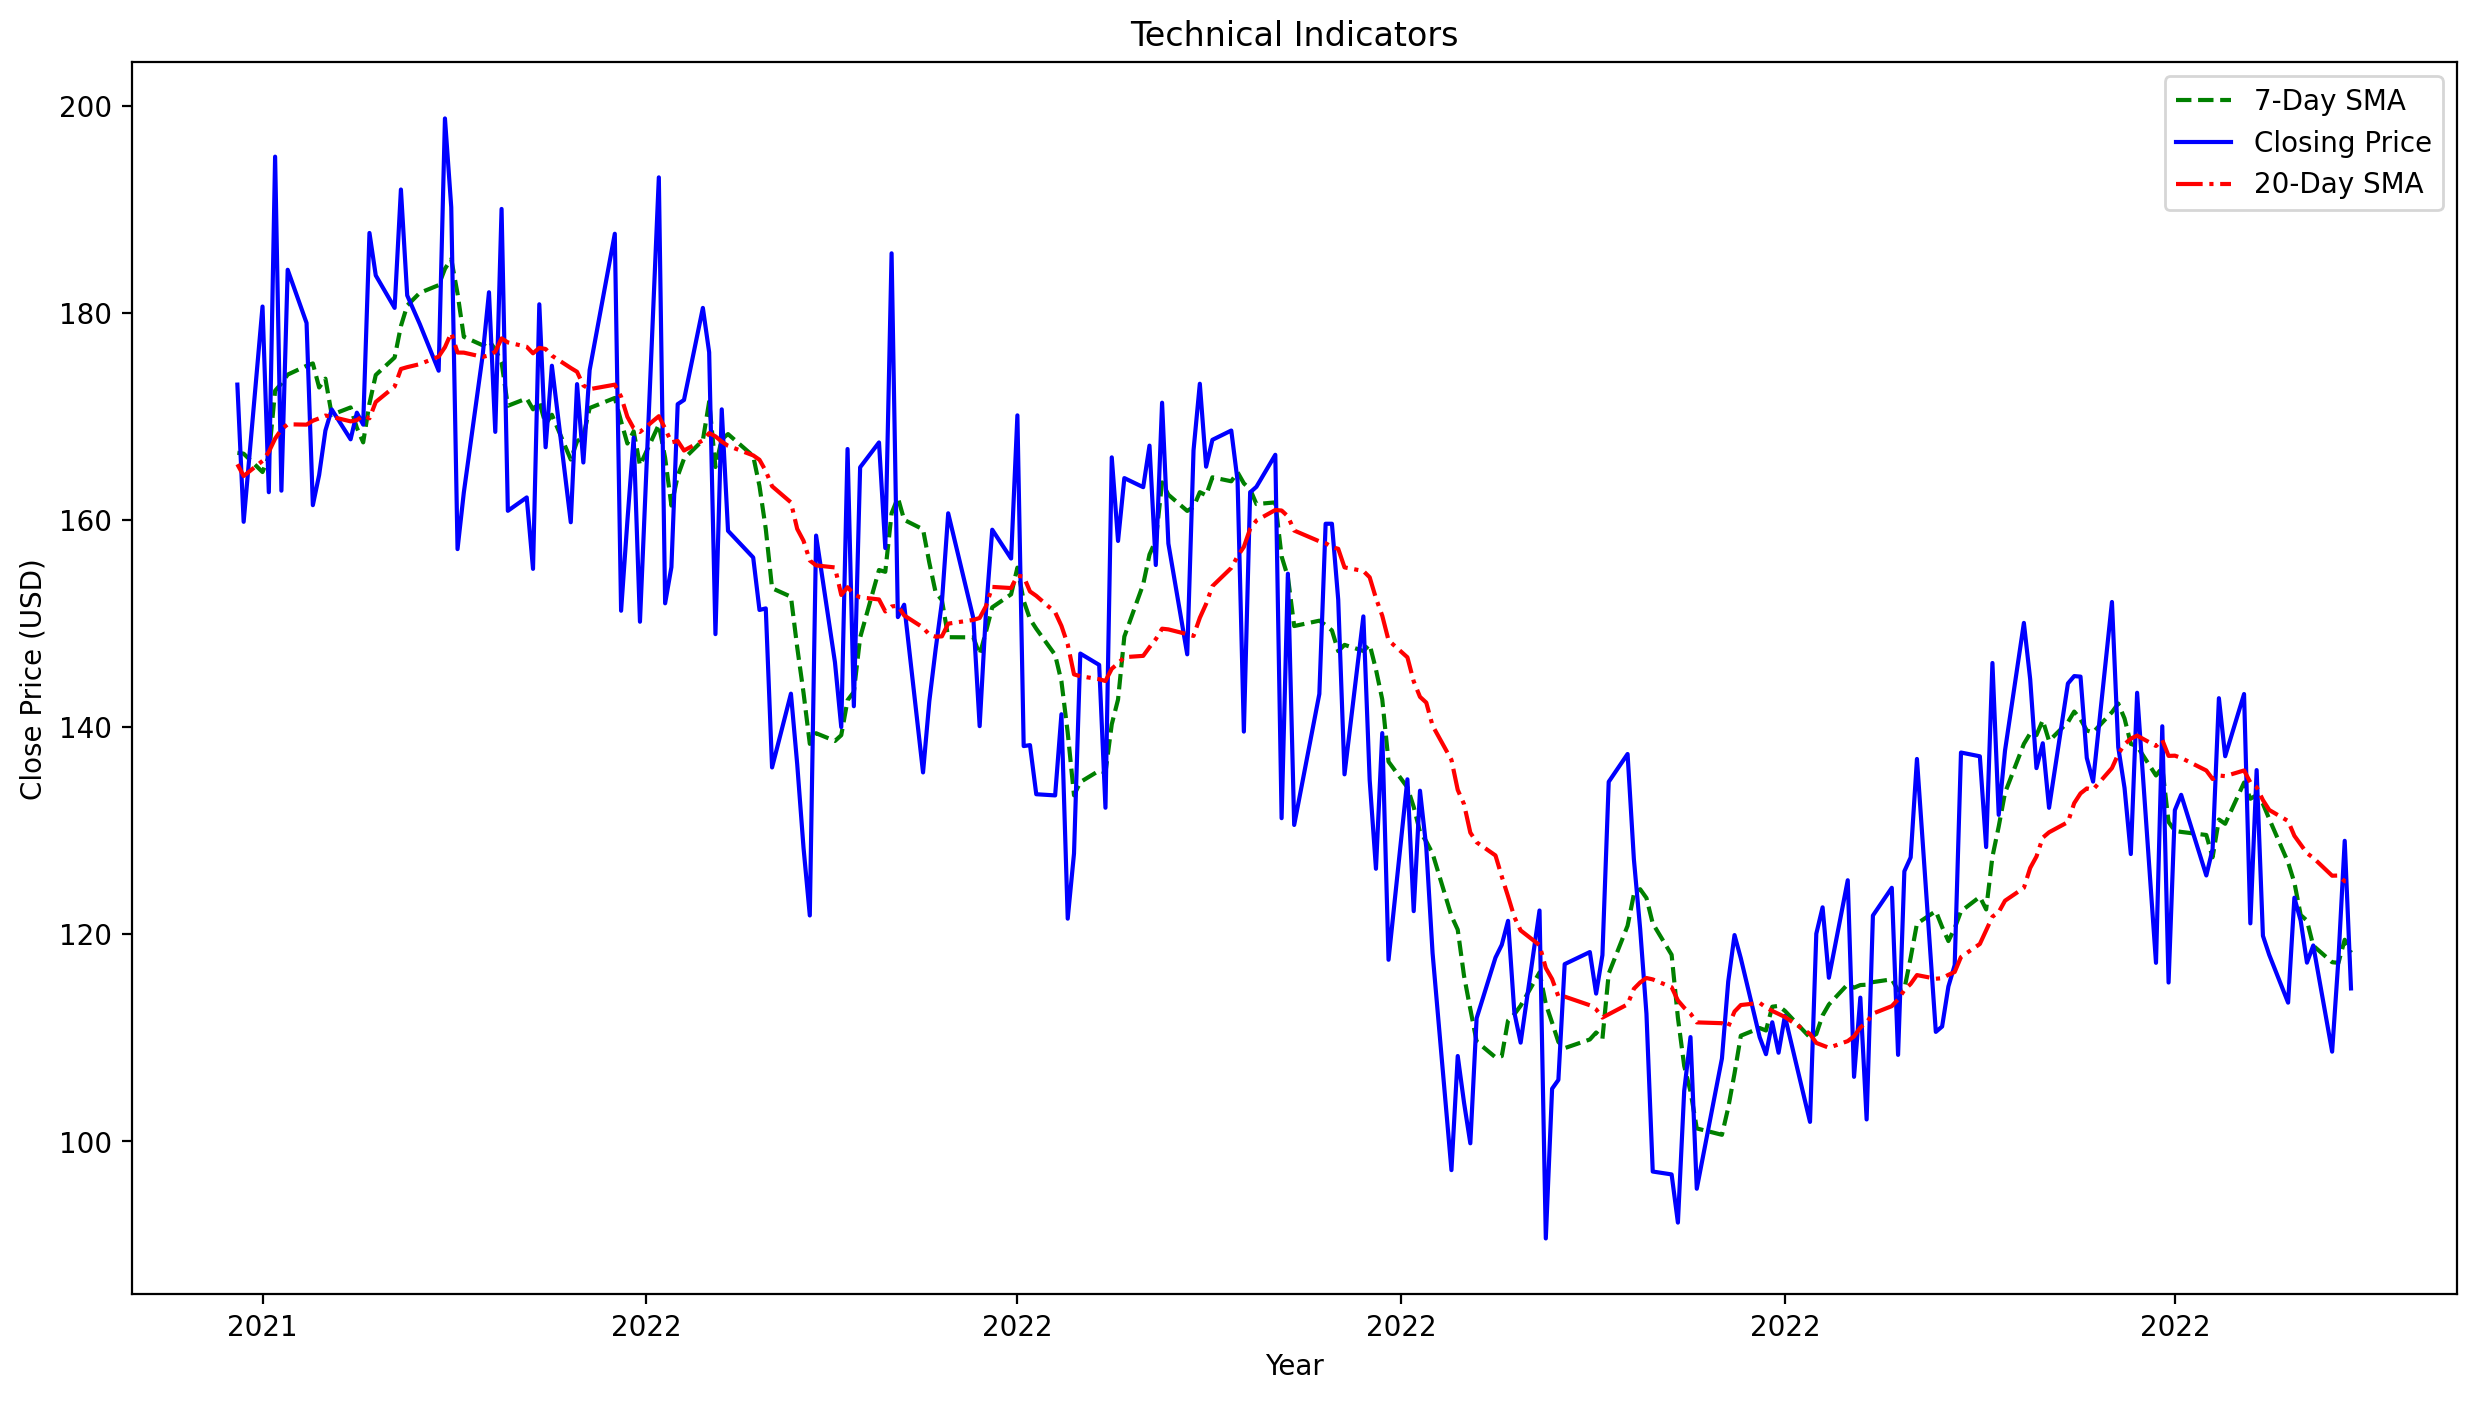

In [ ]:
# Plot technical indicators
def plot_technical_data(tech_data):
    fig, ax = plt.subplots(figsize=(15, 8), dpi=200)
    ax.plot(tech_data['Processed_Date'], tech_data['SMA7'], label='7-Day SMA', color='green', linestyle='--')
    ax.plot(tech_data['Processed_Date'], tech_data['Close'], label='Closing Price', color='blue')
    ax.plot(tech_data['Processed_Date'], tech_data['SMA20'], label='20-Day SMA', color='red', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical Indicators')
    plt.ylabel('Close Price (USD)')
    plt.xlabel('Year')
    plt.legend()
    plt.show()

plot_technical_data(technical_stock_data)

In [ ]:
# Fill missing values
filled_data = technical_stock_data.iloc[:, 1:].ffill()

In [ ]:
# Convert dates to datetime index
datetime_series = pd.to_datetime(technical_stock_data['Processed_Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
time_series_data = technical_stock_data.set_index(datetime_index)
time_series_data = time_series_data.sort_values(by='Processed_Date')
time_series_data = time_series_data.drop(columns='Processed_Date')

In [ ]:
# Normalize the data
def scale_data(df, scale_range, target_col):
    # Select only numeric columns for scaling
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    target_series = pd.DataFrame(df[target_col])
    data = df[numeric_cols]

    scaler_features = MinMaxScaler(feature_range=scale_range)
    scaler_target = MinMaxScaler(feature_range=scale_range)

    scaled_features = scaler_features.fit_transform(data)
    scaled_target = scaler_target.fit_transform(target_series)

    joblib.dump(scaler_features, open('feature_scaler.pkl', 'wb'))
    joblib.dump(scaler_target, open('target_scaler.pkl', 'wb'))


    return scaled_features, scaled_target

In [ ]:
# Batch the data
def batch_dataset(features, targets, batch_sz, forecast_period):
    batched_features, batched_targets, batched_continued = [], [], []
    for i in range(len(features)):
        feature_batch = features[i: i + batch_sz]
        target_batch = targets[i + batch_sz: i + batch_sz + forecast_period, 0]
        continued_batch = targets[i: i + batch_sz]
        if len(feature_batch) == batch_sz and len(target_batch) == forecast_period:
            batched_features.append(feature_batch)
            batched_targets.append(target_batch)
            batched_continued.append(continued_batch)
    return np.array(batched_features), np.array(batched_targets), np.array(batched_continued)

In [ ]:
# Split the data into training and testing sets
def divide_data(data):
    split_point = int(len(data) * 0.8)
    training_set, testing_set = data[:split_point], data[split_point:]
    return training_set, testing_set

# Determine prediction indices for training and testing
def determine_prediction_indices(full_data, train_data, batch_sz, forecast_horizon):
    training_indices = full_data.iloc[batch_sz: len(train_data) + batch_sz + forecast_horizon].index
    testing_indices = full_data.iloc[len(train_data) + batch_sz:].index
    return training_indices, testing_indices

scaled_features, scaled_targets = scale_data(time_series_data, (-1, 1), "Close")
batched_features, batched_targets, continued_batches = batch_dataset(scaled_features, scaled_targets, batch_sz=5, forecast_period=1)
print("Batched features shape:", batched_features.shape)
print("Batched targets shape:", batched_targets.shape)
print("Continued batches shape:", continued_batches.shape)

Batched features shape: (227, 5, 15)
Batched targets shape: (227, 1)
Continued batches shape: (227, 5, 1)


In [ ]:
train_features, test_features = divide_data(batched_features)
train_targets, test_targets = divide_data(batched_targets)
continued_train, continued_test = divide_data(continued_batches)
train_indices, test_indices = determine_prediction_indices(time_series_data, train_features, 5, 1)

In [ ]:
# Model dimensions
input_dimensions = train_features.shape[1]
features_count = train_features.shape[2]
target_dimensions = train_targets.shape[1]

# Generator model
def create_generator(input_dim, output_dim, feature_count):
    model = Sequential([
        LSTM(1024, return_sequences=True, input_shape=(input_dim, feature_count), recurrent_dropout=0.3),
        LSTM(512, return_sequences=True, recurrent_dropout=0.3),
        LSTM(256, return_sequences=True, recurrent_dropout=0.3),
        LSTM(128, return_sequences=True, recurrent_dropout=0.3),
        LSTM(64, recurrent_dropout=0.3),
        Dense(32),
        Dense(16),
        Dense(8),
        Dense(output_dim)
    ])
    return model

In [ ]:
# Discriminator model
def create_discriminator(input_dim):
    model = Sequential()
    model.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(0.01)))
    model.add(Conv1D(16, 3, 2, 'same', activation=LeakyReLU(0.01)))
    model.add(Conv1D(32, 3, 2, 'same', activation=LeakyReLU(0.01)))
    model.add(Conv1D(64, 3, 2, 'same', activation=LeakyReLU(0.01)))
    model.add(Conv1D(128, 1, 2, 'same', activation=LeakyReLU(0.01)))
    model.add(LeakyReLU())
    model.add(Dense(220, activation='relu', use_bias=False))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Loss functions
def gen_loss_function(fake_output):
    loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return loss_func(tf.ones_like(fake_output), fake_output)

def disc_loss_function(real_output, fake_output):
    loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_func(tf.ones_like(real_output), real_output)
    fake_loss = loss_func(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# Training step
@tf.function
def training_step(input_x, target_y, continued_y, gen_model, disc_model, gen_optimizer, disc_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_y = gen_model(input_x, training=True)
        reshaped_generated_y = tf.reshape(generated_y, [generated_y.shape[0], generated_y.shape[1], 1])
        fake_input = tf.concat([tf.cast(reshaped_generated_y, tf.float64), continued_y], axis=1)
        reshaped_target_y = tf.reshape(target_y, [target_y.shape[0], target_y.shape[1], 1])
        real_input = tf.concat([reshaped_target_y, continued_y], axis=1)

        real_output = disc_model(real_input, training=True)
        fake_output = disc_model(fake_input, training=True)

        gen_loss = gen_loss_function(fake_output)
        disc_loss = disc_loss_function(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, disc_model.trainable_variables))

    return target_y, generated_y, {'disc_loss': disc_loss, 'gen_loss': gen_loss}

In [ ]:
from tqdm import tqdm


# Training process
def execute_training(input_features, target_values, continued_values, total_epochs, gen_model, disc_model, gen_opt, disc_opt, checkpoint_interval=50):
    training_details = {"gen_loss": [], "disc_loss": []}

    for epoch in tqdm(range(total_epochs)):
        real_vals, predicted_vals, losses = training_step(input_features, target_values, continued_values, gen_model, disc_model, gen_opt, disc_opt)
        training_details["gen_loss"].append(losses['gen_loss'].numpy())
        training_details["disc_loss"].append(losses['disc_loss'].numpy())

        if (epoch + 1) % checkpoint_interval == 0:
            gen_model.save(f'./model_saves/{selected_stock}/gen_model_epoch_{epoch}.h5')
            disc_model.save(f'./model_saves/{selected_stock}/disc_model_epoch_{epoch}.h5')
            print(f'Epoch {epoch + 1}, Generator Loss: {losses["gen_loss"].numpy()}, Discriminator Loss: {losses["disc_loss"].numpy()}')

    return training_details, real_vals, predicted_vals

In [ ]:
# Model configurations
learning_rate = 0.0005
num_epochs = 500
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Initialize models
generator_model = create_generator(input_dimensions, target_dimensions, features_count)
discriminator_model = create_discriminator(input_dimensions)

# Train models
training_results, actual_prices, forecasted_prices = execute_training(train_features, train_targets, continued_train, num_epochs, generator_model, discriminator_model, gen_optimizer, disc_optimizer)

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
 10%|▉         | 49/500 [01:51<13:24,  1.78s/it]/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
 10%|█         | 50/500 [01:53<13:09,  1.75s/it]

Epoch 50, Generator Loss: 0.711111307144165, Discriminator Loss: 1.3919527530670166


 20%|██        | 100/500 [03:20<11:45,  1.76s/it]

Epoch 100, Generator Loss: 0.694770872592926, Discriminator Loss: 1.3883087635040283


 30%|███       | 150/500 [04:49<12:43,  2.18s/it]

Epoch 150, Generator Loss: 0.6892035007476807, Discriminator Loss: 1.3863719701766968


 40%|████      | 200/500 [06:17<10:02,  2.01s/it]

Epoch 200, Generator Loss: 0.7007123231887817, Discriminator Loss: 1.3943841457366943


 50%|█████     | 250/500 [07:50<07:32,  1.81s/it]

Epoch 250, Generator Loss: 0.6903594732284546, Discriminator Loss: 1.3872838020324707


 60%|██████    | 300/500 [09:18<07:21,  2.21s/it]

Epoch 300, Generator Loss: 0.6948517560958862, Discriminator Loss: 1.3880815505981445


 70%|███████   | 350/500 [10:47<04:32,  1.82s/it]

Epoch 350, Generator Loss: 0.6937996745109558, Discriminator Loss: 1.3870155811309814


 80%|████████  | 400/500 [12:12<02:39,  1.60s/it]

Epoch 400, Generator Loss: 0.6936627626419067, Discriminator Loss: 1.3853129148483276


 90%|█████████ | 450/500 [13:39<01:23,  1.66s/it]

Epoch 450, Generator Loss: 0.7291961908340454, Discriminator Loss: 1.3851515054702759


100%|██████████| 500/500 [15:05<00:00,  1.81s/it]

Epoch 500, Generator Loss: 0.7023785710334778, Discriminator Loss: 1.3862066268920898


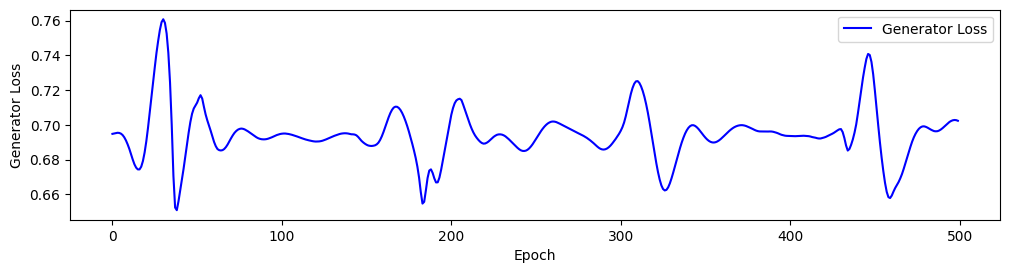

In [ ]:
# Plot training results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(training_results["gen_loss"], label='Generator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.legend()

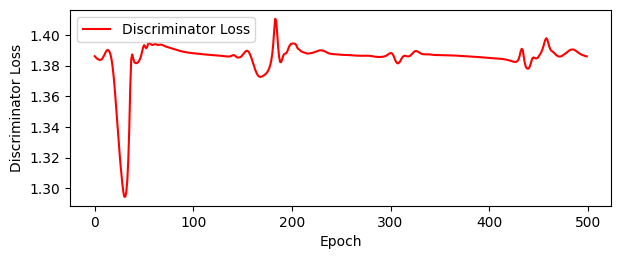

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(training_results["disc_loss"], label='Discriminator Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Discriminator Loss')
plt.legend()
plt.tight_layout()
plt.show()

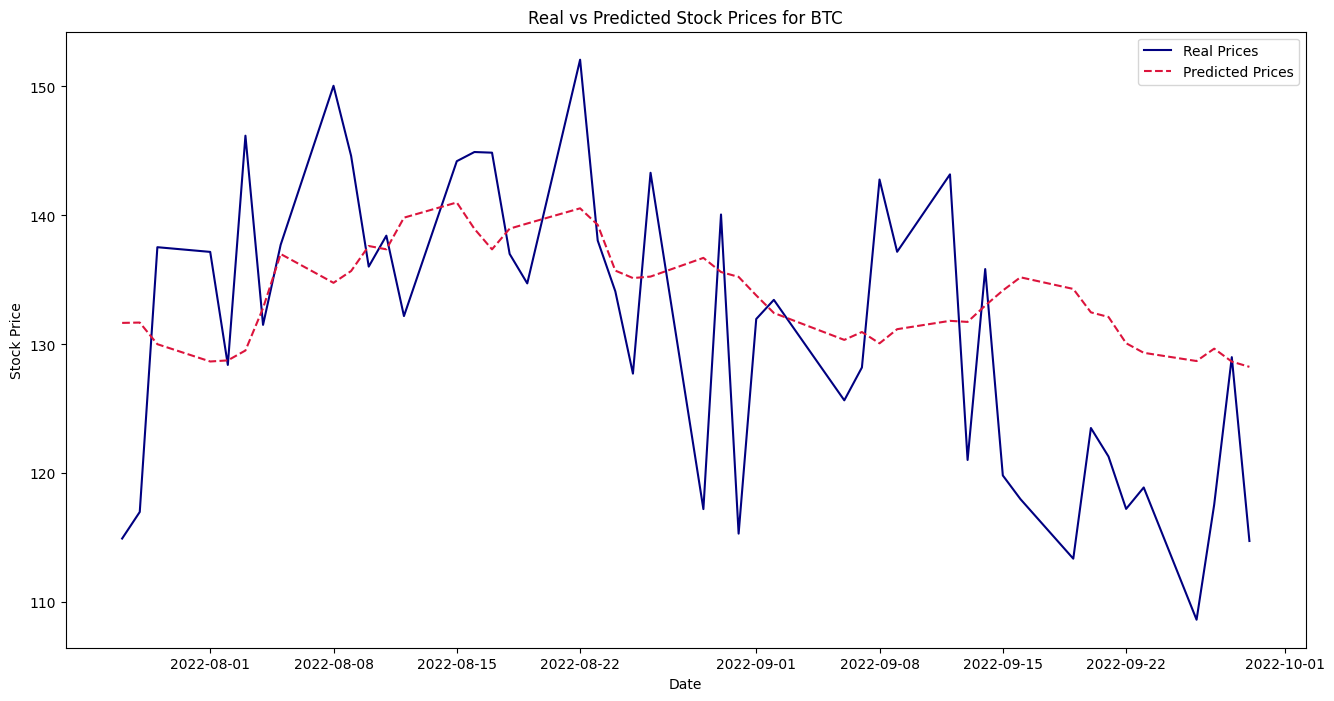

In [ ]:
# Load trained generator for prediction
trained_gen_model = tf.keras.models.load_model(f'./model_saves/{selected_stock}/gen_model_epoch_{num_epochs-1}.h5')

# Evaluation function
@tf.function
def evaluate_model(model, input_features):
    return model(input_features, training=False)

# Plot test data
def plot_test_results(real_test_prices, predicted_test_prices, test_indices):
    feature_scaler = joblib.load(open('feature_scaler.pkl', 'rb'))
    target_scaler = joblib.load(open('target_scaler.pkl', 'rb'))


    rescaled_real_prices = target_scaler.inverse_transform(real_test_prices)
    rescaled_predicted_prices = target_scaler.inverse_transform(predicted_test_prices)

    plt.figure(figsize=(16, 8))
    plt.plot(test_indices, rescaled_real_prices, color='navy', label='Real Prices')
    plt.plot(test_indices, rescaled_predicted_prices, color='crimson', linestyle='--', label='Predicted Prices')
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title(f"Real vs Predicted Stock Prices for {selected_stock}")
    plt.legend()
    plt.show()

# Predict using the test data
predicted_test = evaluate_model(trained_gen_model, test_features)
plot_test_results(test_targets, predicted_test, test_indices)